In [1]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter
from matplotlib import animation
from scipy import stats

import sys; sys.path.insert(1, '/saturn/simu_Caribbean/coupled_2km')
import os

import geometry as gm
#import conversion as cnv
#from func_statistics import compute_pdf_nbin, slopes_r_p, slope_time, slope_maps
from pdist_fb_distrib_save_fast import *
#from coare_functions import *
import meteo
import lcl
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
import warnings; warnings.filterwarnings("ignore")

# Building a new Fourier mask for FORCED

In [4]:
# read  data
path_data = '/saturn/simu_Caribbean/forced_3km/CNT/FEB/01/'
wrf_files = path_data + 'wrfout_d02_2020-0'
fname_list = sorted(glob.glob(wrf_files + '*'))
ds = xr.open_mfdataset(fname_list, concat_dim='Time', combine='nested')

In [5]:
minlon = -60.; maxlon = -51.
minlat = 0.; maxlat = 17.
# select domain
mask_lon = (ds.XLONG >= minlon) & (ds.XLONG <= maxlon)
mask_lat = (ds.XLAT >= minlat) & (ds.XLAT <= maxlat)
ds = ds.where(mask_lon & mask_lat, drop=True)

In [6]:
# def lon lat time
lon = ds['XLONG'][0].values
lat = ds['XLAT'][0].values
time = ds['XTIME'].values.astype('<M8[s]')
# land - sea mask
lakemask = ds['LAKEMASK'][0].values
landmask = ds['LANDMASK'][0].values
seamask = 1 - lakemask - landmask
seamask[seamask==0] = np.nan
# def extended land-sea mask
seamask_nocoast = seamask.copy(); seamask_island0 = seamask.copy()
seamask_island0[:int(seamask_island0.shape[0]/2),:] = 1
seamask_island = seamask_island0.copy()
for i in range(0,5):
    for j in range(0,5):
        seamask_nocoast = np.roll(seamask, (i,j), axis=(1,0))*seamask_nocoast
        seamask_island = np.roll(seamask_island0, (-i,-j), axis=(1,0))*seamask_island
seamask_nocoast = seamask_nocoast*seamask_island
seamask = seamask_nocoast.copy()
del seamask_nocoast, lakemask, landmask

In [8]:
sst_ff = ds['SST'].groupby('XTIME.day').mean().values*seamask - 273.15 # °C

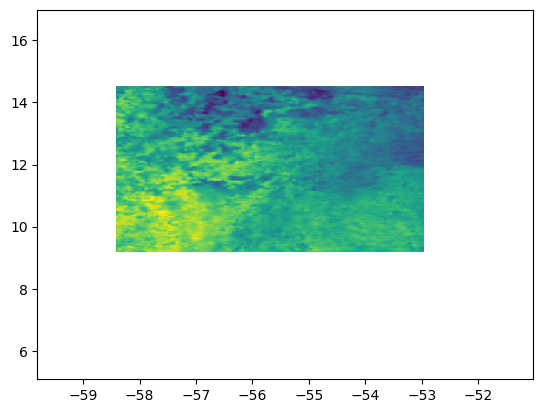

In [21]:
fourier_mask = seamask.copy()
fourier_mask[0:151, :] = np.nan
fourier_mask[351:, :] = np.nan

fourier_mask[:, 0:51] = np.nan
fourier_mask[:, 251:] = np.nan


plt.pcolormesh(lon, lat, sst_ff[0]*fourier_mask)



In [23]:
np.sqrt(np.nansum(fourier_mask))
    
my_save_data('/home/alessandro/thesis_material/EURECA_scripts/masks/fourier_forced.npy', [fourier_mask])

creating new file and saving variables


In [7]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'

wrf_files = path + 'Caraibes_WRF_3h_surf.nc'
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [8]:
# open data - HOURLY
ds_hourly = xr.open_dataset(wrf_files)    #mfdataset(fname_list, concat_dim='Time', combine='nested')
'''ds_hourly = ds_tot.sel(time_counter=slice('2006-02-01T00:30:00.000000000', '2006-02-29T22:30:00.000000000'))
del ds_tot'''
# lat and lon
lon = ds_hourly['nav_lon'].values
lat = ds_hourly['nav_lat'].values


In [20]:
sst = ds_hourly['SST'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

sst = sst.groupby('time_counter.day').mean()
sst = sst-273.15

In [21]:
sst_day = sst

In [4]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_new.npy')
    
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask_modified = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')
    sea_mask_modified_nan = np.ones_like(sea_mask_modified)
    sea_mask_modified_nan[sea_mask_modified==0] = np.nan


In [6]:
# ridefinizione di una nuova maschera
# togliendo la patch più calda vicino alla costa 
# margine sud

In [12]:
with open('/venus/tesi_ale/data_EU/SST/daily/FEB/dSST_day_feb.npy', 'rb') as f:
    dsst_day = np.load(f)

In [13]:
### extracting square for FFT spectrum

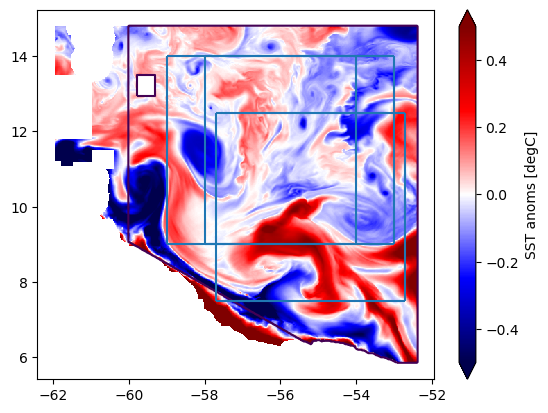

In [15]:
plt.pcolormesh(lon, lat, dsst_day[25], vmin=-0.5, vmax=0.5, cmap='seismic')
plt.colorbar(extend='both', label='SST anoms [degC]')

plt.contour(lon, lat, sea_mask_modified, levels=[0.])

# fourier 1
plt.hlines(9, xmin=-59, xmax=-54)
plt.hlines(14, xmin=-59, xmax=-54)
plt.vlines(-54, ymin=9, ymax=14)
plt.vlines(-59, ymin=9, ymax=14)



# fourier 2
plt.hlines(9, xmin=-58, xmax=-53)
plt.hlines(14, xmin=-58, xmax=-53)
plt.vlines(-53, ymin=9, ymax=14)
plt.vlines(-58, ymin=9, ymax=14)


# fourier 3
plt.hlines(7.5, xmin=-57.7, xmax=-52.7)
plt.hlines(12.5, xmin=-57.7, xmax=-52.7)
plt.vlines(-52.7, ymin=7.5, ymax=12.5)
plt.vlines(-57.7, ymin=7.5, ymax=12.5)

# plt.hlines(9, xmin=lon_M[0,250], xmax=lon_M[0,500])
# plt.hlines(14, xmin=lon_M[0,250], xmax=lon_M[0,500])
# plt.vlines(lon_M[0,500], ymin=lat_M[200,0] , ymax=lat_M[450,0])
# plt.vlines(lon_M[0,250], ymin=lat_M[200,0] , ymax=lat_M[450,0])

In [17]:
fourier_1 = sea_mask.copy()
fourier_1[(lon<-57.7) | (lon>-52.7)] = np.nan
fourier_1[(lat<7.5) | (lat>12.5)] = np.nan


In [31]:
non_nan_mask = ~np.isnan(fourier_1)

# Determine the bounding box of non-NaN values
rows, cols = np.where(non_nan_mask)
min_row, max_row = rows.min(), rows.max()
min_col, max_col = cols.min(), cols.max()

# Adjust the dimensions to keep a 273x273 non-NaN region
# This will remove excess rows (last 4 rows) to ensure the region fits within 273x273
desired_row_end = min_row + 273
desired_col_end = min_col + 273

# Apply the slicing to the original array
result = fourier_1[min_row:desired_row_end, min_col:desired_col_end]
fourier_1[desired_row_end:, :] = np.nan

(546, 573)
273.0


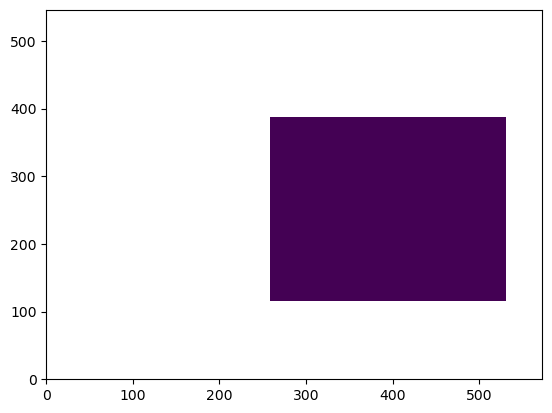

In [32]:
plt.pcolormesh(fourier_1)
print(fourier_1.shape)

print(np.nansum(fourier_1[:,400]))

In [33]:
my_save_data('/home/alessandro/thesis_material/EURECA_scripts/masks/fourier_3.npy', [fourier_1])

file already exists - DELETING IT and creating it anew


In [2]:
fourier_3 = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/fourier_3.npy')

## building a NW-SE oriented mask for autocorrelation testing

In [18]:
# lon   lat
# -55.5   6.5
# -59   8.5
xlon_index = np.argwhere((lon_M[0,:]>-57) & (lon_M[0,:]<-54))
xlon = lon_M[0,xlon_index]

m = -2

ylat = (xlon+54)*m+8.5
ylat2 = (xlon+55)*m+8.5


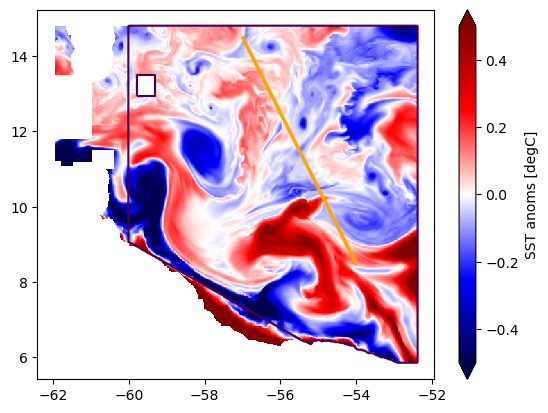

In [20]:
plt.pcolormesh(lon_M, lat_M, dsst_day[25], vmin=-0.5, vmax=0.5, cmap='seismic')
plt.colorbar(extend='both', label='SST anoms [degC]')

plt.contour(lon_M, lat_M, sea_mask_modified, levels=[0.])

plt.plot(xlon, ylat, 'orange', linewidth=2.5)
#plt.plot(xlon, ylat2, 'orange', linewidth=2.5)


In [28]:
lat_line  = (lon_M[0,:]+54)*m+8.5
lat_line2 = (lon_M[0,:]+55)*m+8.5

channel = sea_mask_modified.copy()

for i in range(len(lat_M[0,:])):
    channel[ (lat_M[:,i]<lat_line[i]) & (lat_M[:,i]>lat_line2[i]),i ] = 0
    
channel_nan = np.where((1-channel)==0, np.nan, 1)
channel_nan *= sea_mask_modified_nan

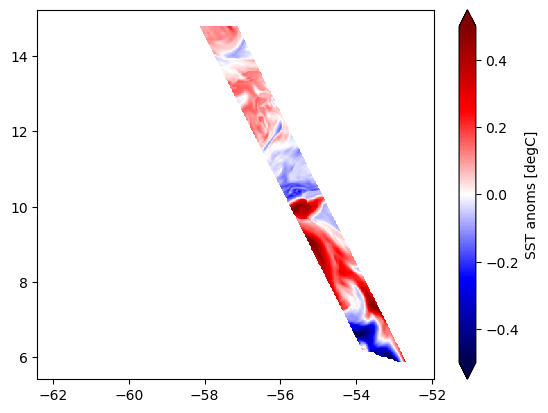

In [29]:
plt.pcolormesh(lon_M, lat_M, dsst_day[25]*channel_nan, vmin=-0.5, vmax=0.5, cmap='seismic')
plt.colorbar(extend='both', label='SST anoms [degC]')

#plt.contour(lon_M, lat_M, channel, levels=[1.])


In [30]:
my_save_data('/home/alessandro/thesis_material/EURECA_scripts/masks/channel_autocorr.npy', [channel_nan])

creating new file and saving variables


In [21]:
# lon   lat
# -55.5   6.5
# -59   8.5
# xlon_index = np.argwhere((lon_M[0,:]>-59) & (lon_M[0,:]<-55.5))
# xlon = lon_M[0,xlon_index]

m = (8.5-6.5)/(-59+55.5)

# ylat = (xlon+55.5)*m+6.5



####  finding the boulevard dwes tourbillons
xlon_idx_turb = np.argwhere((lon_M[0,:]>-60) & (lon_M[0,:]<-52))
xlon_turb = lon_M[0,xlon_idx_turb]
ylat_turb = (xlon_turb+52)*m+7


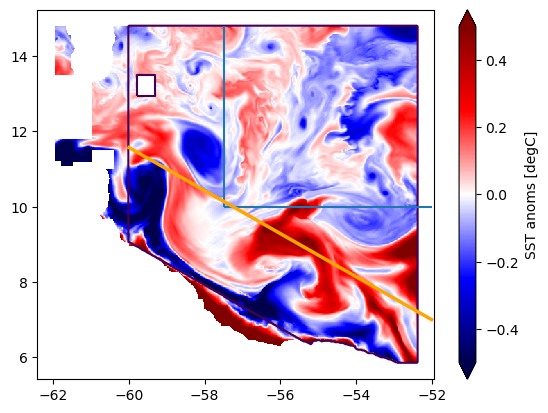

In [29]:
plt.pcolormesh(lon_M, lat_M, dsst_day[25], vmin=-0.5, vmax=0.5, cmap='seismic')
plt.colorbar(extend='both', label='SST anoms [degC]')

plt.contour(lon_M, lat_M, sea_mask_modified, levels=[0.])

plt.plot(xlon_turb, ylat_turb, 'orange', linewidth=2.5)


plt.hlines(10, xmin=-57.5, xmax=-52)
plt.vlines(-57.5, ymin=10, ymax=14.8)

In [26]:
lat_line = (lon_M[0,:]+55.5)*m+6.5


for i in range(len(lat_M[0,:])):
    sea_mask[ lat_M[:,i]<lat_line[i],i ] = 0


In [30]:
my_save_data('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_noWarmPatch_noWest.npy', [sea_mask_alternative])

creating new file and saving variables


In [31]:
######### tourbillons

lat_line_turb = (lon_M[0,:]+52)*m+7

tourbillons_mask = sea_mask_modified.copy()

for i in range(len(lat_M[0,:])):
    tourbillons_mask[ lat_M[:,i]>lat_line_turb[i],i ] = 0

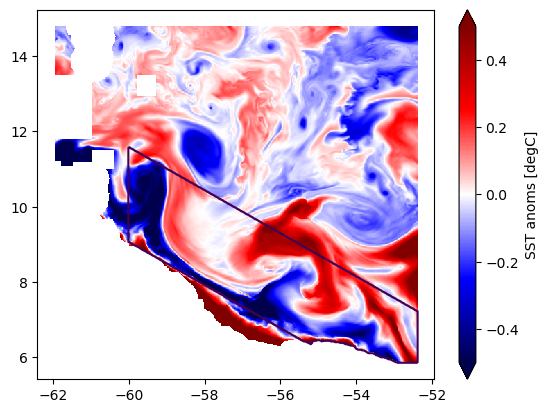

In [32]:
plt.pcolormesh(lon_M, lat_M, dsst_day[25], vmin=-0.5, vmax=0.5, cmap='seismic')
plt.colorbar(extend='both', label='SST anoms [degC]')

plt.contour(lon_M, lat_M, tourbillons_mask, levels=[0.])

In [33]:
tourbillons_mask[tourbillons_mask==0] = np.nan

In [34]:
my_save_data('/home/alessandro/thesis_material/EURECA_scripts/masks/tourbillons_mask.npy', [tourbillons_mask])

creating new file and saving variables


In [39]:
## open ocean
open_ocean_mask = sea_mask_modified.copy()

open_ocean_mask[(lat_M<10)] = 0
open_ocean_mask[lon_M<-57.5] = 0

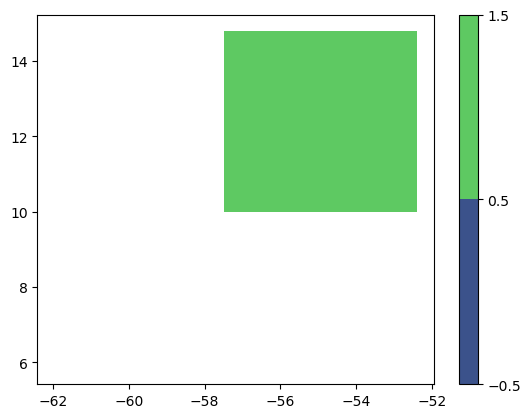

In [48]:
# plt.pcolormesh(lon_M, lat_M, dsst_day[25], vmin=-0.5, vmax=0.5, cmap='seismic')
# plt.colorbar(extend='both', label='SST anoms [degC]')

plt.contourf(lon_M, lat_M, open_ocean_mask, levels=[-0.5, 0.5, 1.5])
plt.colorbar()

In [47]:
open_ocean_mask[open_ocean_mask==0] = np.nan

In [49]:
my_save_data('/home/alessandro/thesis_material/EURECA_scripts/masks/open_ocean_mask.npy', [open_ocean_mask])

creating new file and saving variables


In [28]:
sea_mask_alternative = sea_mask
sea_mask_alternative[lon_M<-60]=0

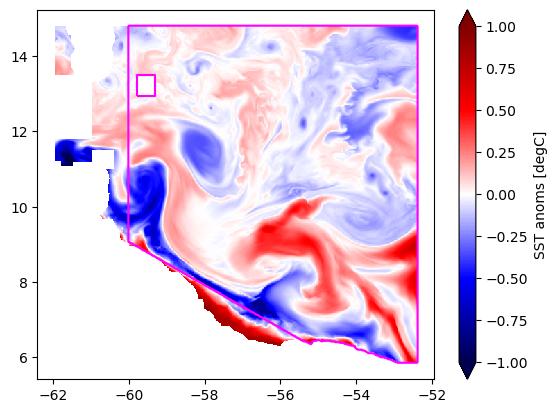

In [29]:
plt.pcolormesh(lon_M, lat_M, dsst_day[25], vmin=-1, vmax=1, cmap='seismic')
plt.colorbar(extend='both', label='SST anoms [degC]')

plt.contour(lon_M, lat_M, sea_mask_alternative, levels=[0.], colors='magenta', linewidth=2.5)

In [5]:
# definizione di STRONG_GRADIENTS e WEAK_GRADIENTS
strong_gradients = np.argwhere((lon_M[1,:]>=-59.) & (lon_M[1,:]<=-52.)& (lat_M>=5.) & (lat_M<=10))



In [10]:
rsh_lat, rsh_lon = len(np.unique(strong_gradients[:,0])), len(np.unique(strong_gradients[:,1]))

In [15]:
sg.shape

(253, 382)

In [18]:
sg_mask, wg_mask = np.zeros_like(sea_mask), np.zeros_like(sea_mask)

# Find indices that match the conditions
strong_gradients = np.argwhere((lon_M[1,:]>=-59.) & (lon_M[1,:]<=-52.) & (lat_M>=5.) & (lat_M<=10))
weak_gradients = np.argwhere((lon_M[1,:]>=-59.) & (lon_M[1,:]<=-52.)& (lat_M>=10) & (lat_M<=14))

# Initialize masks
sg_mask, wg_mask = np.zeros_like(sea_mask), np.zeros_like(sea_mask)

# Use advanced indexing to update the mask correctly
for idx in strong_gradients:
    sg_mask[idx[0], idx[1]] = sea_mask[idx[0], idx[1]]

for miao in weak_gradients:
    wg_mask[miao[0], miao[1]] = sea_mask[miao[0], miao[1]]


In [32]:
my_save_data('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_strongGrads.npy', [sg_mask])
my_save_data('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_weakGrads.npy', [wg_mask])


file already exists - DELETING IT and creating it anew
file already exists - DELETING IT and creating it anew


In [31]:
sg_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_strongGrads.npy')
wg_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_weakGrads.npy')

sg_mask[sg_mask<1] = np.nan
wg_mask[wg_mask<1] = np.nan

In [ ]:
############# QUI CREO UNA NUOVA MASCHERA RIMUOVENDO LE ISOLETTE DI SST CALDA 
############# CHE NON ERANO RICONOSCIUTE COME LAND
############# SALVATA IN sea_mask_EU_new.npy

In [4]:
#########  MASKING

'''#########  start with rect         y = 0:300   , x = 0:end
######### then with small square   y = 400:end , x = 0:150'''
sst = ds_hourly['SST']
sst_mask = sst[10,:,:]/sst[10,:,:]
sst_mask = sst_mask.where(sst_mask>0, other=0, drop=False)
land_mask =  1-sst_mask

In [49]:
# rettangolone
santa_lucia = np.argwhere((lon_M[1,:]>=-62.) & (lon_M[1,:]<=-61.)& (lat_M>=11.8) & (lat_M<=13.5))

# cubetto 2
barbados = np.argwhere((lon_M[1,:]>=-59.8) & (lon_M[1,:]<=-59.3)& (lat_M>=12.93) & (lat_M<=13.5))

# rettangolino
scarborough = np.argwhere((lon_M>=-61.) & (lon_M<=-60.4) & (lat_M>=11.) & (lat_M<=11.5))

# aggiunta
add = np.argwhere((lon_M>=-62.) & (lon_M<=-61.8) & (lat_M>=10.2) & (lat_M<=11.2))

In [52]:
sea_mask[santa_lucia[:,0], santa_lucia[:,1]] = 0
sea_mask[scarborough[:,0], scarborough[:,1]] = 0
sea_mask[barbados[:,0], barbados[:,1]] = 0
sea_mask[add[:,0], add[:,1]] = 0

In [54]:
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_new.npy'):
    np.save('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_new.npy', sea_mask)

Text(0, 0.5, 'lat [$^\\circ$]')

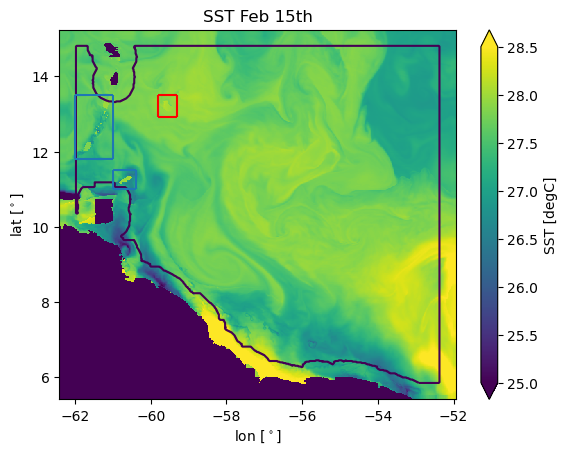

In [42]:
plt.pcolormesh(lon_M, lat_M, sst[15,:,:]-273.15, vmin=25, vmax=28.5, cmap='viridis')
plt.colorbar(extend='both', label='SST [degC]')

plt.contour(lon_M, lat_M, sea_mask, levels=[0.])

# # rettangolone - santa lucia
# plt.hlines(11.8, xmin=-62, xmax=-61, label='1')
# plt.vlines(-61., ymin=11.8, ymax=13.5, label='3')
# plt.hlines(13.5, xmin=-62, xmax=-61, label='1')
# plt.vlines(-62., ymin=11.8, ymax=13.5, label='3')

# # cubetto - scarborough
# plt.hlines(11.5, xmin=-61, xmax=-60.4, label='1')
# plt.vlines(-60.4, ymin=11., ymax=11.5, label='3')
# plt.vlines(-61., ymin=11., ymax=11.5, label='3')
# plt.hlines(11., xmin=-61, xmax=-60.4, label='1')

# # cubetto 2 - barbados
# plt.hlines(12.93, xmin=-59.8, xmax=-59.3, label='1', color='red')
# plt.vlines(-59.8, ymin=12.93, ymax=13.5, label='3', color='red')
# plt.hlines(13.5, xmin=-59.8, xmax=-59.3, label='1', color='red')
# plt.vlines(-59.3, ymin=12.93, ymax=13.5, label='3', color='red')

plt.title(f'SST Feb 15th')
plt.xlabel('lon [$^\circ$]')
plt.ylabel('lat [$^\circ$]')

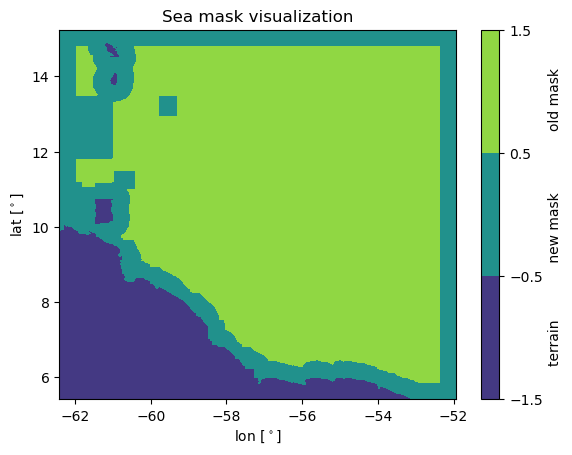

In [53]:
plt.contourf(lon_M, lat_M, -land_mask+sea_mask, levels=[-1.5, -0.5, 0.5, 1.5])
plt.title('Sea mask visualization')
plt.xlabel('lon [$^\circ$]')
plt.ylabel('lat [$^\circ$]')
cbar = plt.colorbar(label='terrain             new mask              old mask ' )

In [11]:
sst = ds_hourly['SST']
sst_mask = sst[10,:,:]/sst[10,:,:]
sst_mask = sst_mask.where(sst_mask>0, other=0, drop=False)
land_mask =  1-sst_mask

#x = sst_mask.x.values

#sst_coords = np.argwhere(sst_mask[:,0:500].values>0)
#land_coords = np.argwhere(land_mask[:,0:500].values>0)

# width of stripe
width=3
depth = int(573/width)

sst_rshp_vert = np.zeros((546,width,int(depth)))
land_rshp_vert = np.zeros((546,width,int(depth)))

for i in range(depth):
    sst_rshp_vert[:,:,i] = sst_mask[:,i*width:(i+1)*width]
    land_rshp_vert[:,:,i] = land_mask[:,i*width:(i+1)*width]


def stripe_funk(sst_rshp_vert_num, land_rshp_vert_num):
    sst_coo = np.argwhere(sst_rshp_vert_num>0)
    land_coo = np.argwhere(land_rshp_vert_num>0)
    
    dist = np.sum((sst_coo[:, None] - land_coo[None, :]) ** 2, axis=-1)
    close_mask = np.any(dist <= 25**2, axis=-1)
    del dist
    
    sst_rshp_vert_num[sst_coo[close_mask][:, 0], sst_coo[close_mask][:, 1]] = 0
    
    #return stripe


        

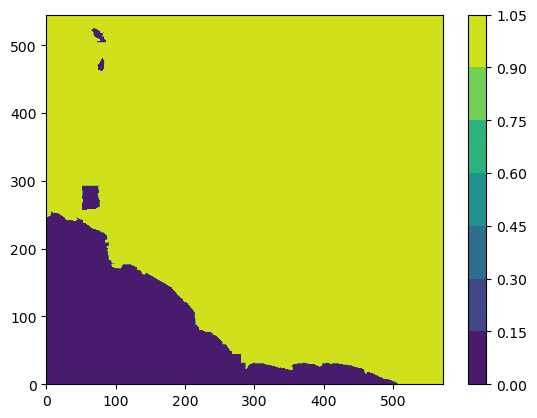

In [6]:
plt.contourf(sst_mask)
plt.colorbar()

In [12]:
for i in range(depth):
    stripe_funk(sst_rshp_vert[:,:,i], land_rshp_vert[:,:,i])


In [14]:
sst_rshp_vert = np.reshape(sst_rshp_vert, (546, 573), order='F')

In [ ]:
'''for i in range(depth-1):
    sst_rshp_vert = np.concatenate((sst_rshp_vert[:,:,i], sst_rshp_vert[:,:,i+1], axis=-1)'''

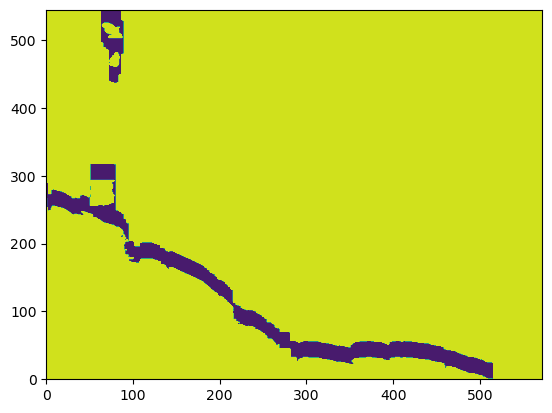

In [40]:
plt.contourf(sst_rshp_vert)

In [86]:
# do the same as before, but horizontal slicing

width = 39
depth = int(546/width)


sst_rshp_hor = np.zeros((depth,width,573))    
land_rshp_hor = np.zeros((depth,width,573))  


for i in range(depth):
    sst_rshp_hor[i,:,:] = sst_mask[i*width:(i+1)*width,:]
    land_rshp_hor[i,:,:] = land_mask[i*width:(i+1)*width,:]

In [87]:
for i in range(depth):   #np.shape(sst_rshp_hor)[-1]
    stripe_funk(sst_rshp_hor[i,:,:], land_rshp_hor[i,:,:])

In [88]:
sst_rshp_hor.shape

(14, 39, 573)

In [89]:
sst_rshp_hor = np.reshape(sst_rshp_hor, (546,573), order='C')

In [81]:
sst_rshp_hor = np.concatenate((sst_rshp_hor[0,:,:], sst_rshp_hor[1,:,:], sst_rshp_hor[2,:,:], sst_rshp_hor[3,:,:], sst_rshp_hor[4,:,:], sst_rshp_hor[5,:,:]), axis=0)   #, sst_mask.values[:,500:]
#sst_rshp_hor = np.concatenate( (sst_rshp_hor, sst_mask.values[:,500:]) , axis=1) 

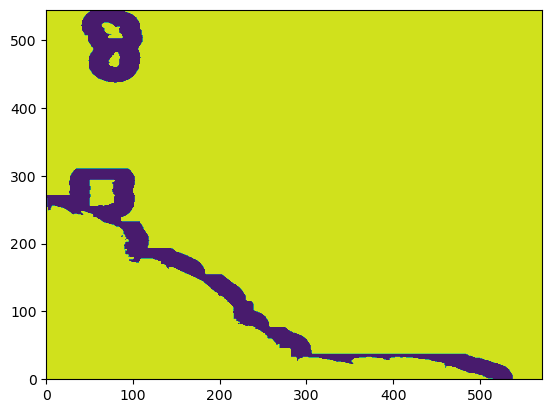

In [90]:
plt.contourf(sst_rshp_hor-sst_mask)

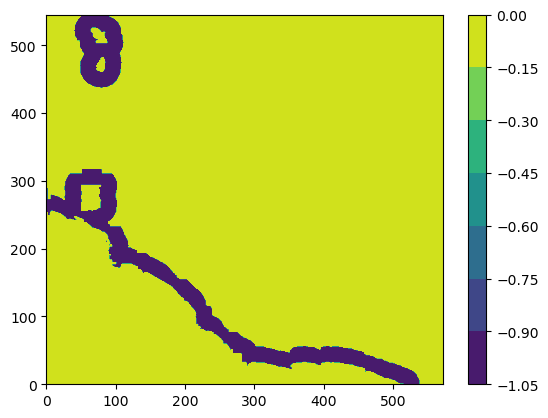

In [91]:
# smooth the two selections
sst_rshp = 0.5*(sst_rshp_hor+sst_rshp_vert)
condition = (sst_rshp == 0.5)
sst_rshp[condition] = 0
plt.contourf(sst_rshp[:,:]-sst_mask[:,:])
plt.colorbar()

In [ ]:
# NOW, SET THE NEW, FINAL MASK
# REMOVE THE TEMPORARY VARS

# sst_rshp is the new sea mask
land_rshp = 1-sst_rshp

del sst_rshp_hor, sst_rshp_vert, land_rshp_vert, land_rshp_vert

In [99]:
# DAMETTERE SU SATURN!

if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU.npy'):
    np.save('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU.npy', sst_rshp)
    
'''if os.path.exist('/home/alessandro/tesi/thesis_material/sea_mask.npy'):   #   /home/alessandro/tesi_ale/prove
    np.save('/home/alessandro/thesis_material/EURECA_scripts/sea_mask.npy', sst_rshp)'''

"if os.path.exist('/home/alessandro/tesi/thesis_material/sea_mask.npy'):   #   /home/alessandro/tesi_ale/prove\n    np.save('/home/alessandro/thesis_material/EURECA_scripts/sea_mask.npy', sst_rshp)"

In [ ]:
######### END OF MASKING

In [ ]:
# ANIMATING THINGS

In [100]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU.npy', allow_pickle=True)

lat = ds_hourly.nav_lat
lon = ds_hourly.nav_lon

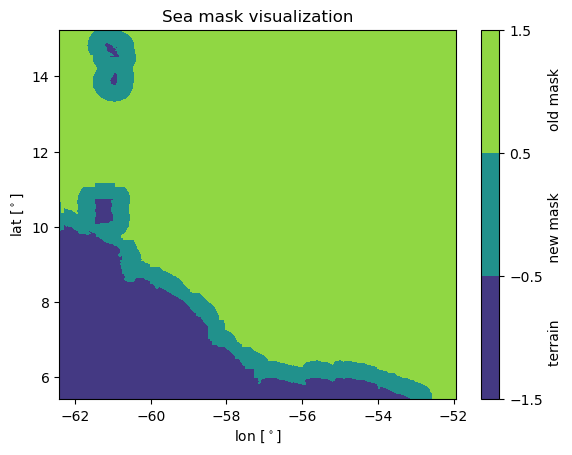

In [101]:
plt.contourf(lon, lat, sea_mask-land_mask, levels=[ -1.5, -0.5, 0.5, 1.5])
plt.title('Sea mask visualization')
plt.xlabel('lon [$^\circ$]')
plt.ylabel('lat [$^\circ$]')
cbar = plt.colorbar(label='terrain             new mask              old mask ' )

#plt.savefig('/home/alessandro/prove/primi_plot/pbl_mask/viz_mask')

In [ ]:
# saving data to visualize
#pblh = ds_hourly['PBLH'];   pblh = pblh.where(sea_mask, drop=False)
sst = ds_hourly['SST'];     sst = sst.where(sea_mask, drop=False)

In [ ]:
######   T2 AND Q2

In [ ]:
# saving other data
T2 = ds_hourly['T2']; T2 = T2.where(sea_mask, drop=False)
q2 = ds_hourly['Q2']; q2 = q2.where(sea_mask, drop=False)
#Tskin = ds_hourly['TSK']; Tskin = Tskin.where(sea_mask, drop=False)

In [ ]:
# enable interactive plot
%matplotlib notebook

#trange = len(np.unique(ds_hourly['time_counter.day'].values[0:-1]))+1   # the last value is another 1 !
trange = len(T2['time_counter'])
trange = np.arange(trange)
frames = np.arange(0,len(trange),3)

date = ds_hourly['time_counter'].values.astype('<M8[s]')
'''date = ['Feb_' + str(  day  ) for day in sfc_wind_day['day'].values]
#date = 'Feb' + ' ' + sfc_wind_day['day'].values.astype(str)'''   


# setting up the figures to be printed
fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(lon[0,0], lon[0,-1]), ylim=(lat[0,0], lat[-1,0]), xlabel='lon [$^\circ$]', ylabel='lat [$^\circ$]')


# initial plot - T2
Tcont = ax.contour(lon, lat, T2[0,:,:]-273.15, levels=12, cmap='YlOrRd')
ax.clabel(Tcont, inline=True, fontsize=10)

# initial plot - q2
qlevs = np.linspace(np.nanmin(q2),np.nanmax(q2),13)*1000;
qcontf = ax.contourf(lon, lat, 1000*q2[0,:,:], levels=qlevs)
cbar = fig.colorbar(qcontf)
cbar.set_label('qvap 2m [g/kg]')

'''# initial  plot - SFC_WIND
wind_levs = np.linspace(np.nanmin(sfc_wind_day),np.nanmax(sfc_wind_day),15)
contf = ax.contourf(lon, lat, sfc_wind_day[0,:,:], levels=wind_levs) 
cbar = fig.colorbar(contf)
cbar.set_label('wind [m/s]')'''

'''# initial  plot - SELECTED WIND POLES
wind_qui = ax.quiver(lon[lat_plot, lon_plot],lat[lat_plot, lon_plot],  u_plot[0,:,:], v_plot[0,:,:], scale=500)
# colors = arctan2(u, v)
# add this to quiver   color=colormap(norm(colors))'''

'''# initial plot - PRESSURE FIELD
isobars = ax.contour(lon, lat, sfc_pres_day[0,:,:]/100., levels=15, cmap='YlOrRd')
ax.clabel(isobars, inline=True, fontsize=10)'''




# Animation function
def animate(i):
    ax.clear()     # clear previous plot
     
    qcontf = ax.contourf(lon, lat, 1000*q2[i,:,:], levels=qlevs)
    cbar.update_normal(qcontf)
    
    Tcont = ax.contour(lon, lat, T2[i,:,:]-273.15, levels=12, cmap='YlOrRd')
    ax.clabel(Tcont, inline=True, fontsize=10)
    
    ax.set_xlabel('lon [$^\circ$]', fontsize=15); ax.set_ylabel('lat [$^\circ$]',fontsize=15)
    ax.set_title(f'T contours [$^\circ$C] and qvap [g/kg], date {date[i]}')   
    

anim = animation.FuncAnimation(fig, animate, interval=200, frames=frames, repeat=False)

plt.show()


In [ ]:
writer = PillowWriter(fps=2,metadata=dict(artist='Me'),bitrate=1800)
anim.save('/home/alessandro/prove/animazioni/q2_T2.gif', writer=writer)

In [ ]:
######   END  T2 AND Q2

In [ ]:
####### ANIMATING SST-T2

In [ ]:
buoyancy = sst-T2

In [ ]:
# enable interactive plot
%matplotlib notebook

#trange = len(np.unique(ds_hourly['time_counter.day'].values[0:-1]))+1   # the last value is another 1 !
trange = len(T2['time_counter'])
trange = np.arange(trange)
frames = np.arange(0,len(trange),3)

date = ds_hourly['time_counter'].values.astype('<M8[s]')
'''date = ['Feb_' + str(  day  ) for day in sfc_wind_day['day'].values]
#date = 'Feb' + ' ' + sfc_wind_day['day'].values.astype(str)'''   


# setting up the figures to be printed
fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(lon[0,0], lon[0,-1]), ylim=(lat[0,0], lat[-1,0]), xlabel='lon [$^\circ$]', ylabel='lat [$^\circ$]')


# initial plot - SST - T2
# UNDERSTAND 
levs = np.linspace(-9, 9, 17)   #np.linspace(np.nanmin(buoyancy),np.nanmax(buoyancy),13) 
dT_contf = ax.contourf(lon, lat, buoyancy[0,:,:], levels=levs, cmap='bwr', extend="both")
cbar = fig.colorbar(dT_contf)
cbar.set_label('SST-T2 [K]')



# Animation function
def animate(i):
    ax.clear()     # clear previous plot
     
    dT_contf = ax.contourf(lon, lat, buoyancy[i,:,:], levels=levs, cmap='bwr', extend="both")
    cbar.update_normal(dT_contf)
    
    '''Tcont = ax.contour(lon, lat, T2[i,:,:]-273.15, levels=12, cmap='YlOrRd')
    ax.clabel(Tcont, inline=True, fontsize=10)'''
    
    ax.set_xlabel('lon [$^\circ$]', fontsize=15); ax.set_ylabel('lat [$^\circ$]',fontsize=15)
    ax.set_title(f'SST-T2 [K], date {date[i]}')   
    

anim = animation.FuncAnimation(fig, animate, interval=200, frames=frames, repeat=False)

plt.show()

In [ ]:
##### END OF SST-T2

In [ ]:
######## ANIMATING SST ANOMS AT 200KM

In [ ]:
# compute dsst - HOURLY DATA TAKE TIME TO FILTER
dsst = np.zeros(sst.values.shape)
s = 100
for t in range(0,sst.values.shape[0]):
    if t % 100 == 0:
        print(t)

    # upscale using gaussian filter
    sst_ave = gm.nan_gaussian_filter(sst[t],s)          
    dsst[t] = sst[t] - sst_ave

In [ ]:
# enable interactive plot
%matplotlib notebook

trange = len(ds_hourly['time_counter'].values)
trange = np.arange(trange)
frames = np.arange(0,len(trange),6)

date = ds_hourly['time_counter'].values.astype('<M8[s]')


# setting the levels I need
#levs = np.linspace(0,np.max(pblh),15) 



# setting up the figures to be printed
fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(lon[0,0], lon[0,-1]), ylim=(lat[0,0], lat[-1,0]), xlabel='lon [$^\circ$]', ylabel='lat [$^\circ$]')

# initial  plot - SST
#Tcont = ax.contour(lon,lat,sst[0,:,:]-273.15, levels=10, cmap='jet')
#ax.clabel(Tcont, inline=True, fontsize=10)

# initial  plot - dSST
norm = colors.TwoSlopeNorm(vmin=np.nanmin(dsst), vcenter=0., vmax=np.nanmax(dsst))

dsst_levs_min= np.linspace(np.nanmin(dsst),0,13);  dsst_levs_max=np.linspace(0,np.nanmax(dsst), 9)
dsst_levs = np.concatenate( (dsst_levs_min, dsst_levs_max))
dsst_levs = np.unique(dsst_levs)

#adj_levs = dsst_levs - 0.5*(np.nanmin(dsst)+np.nanmax(dsst)) 
contf = ax.contourf(lon, lat, dsst[0,:,:],  cmap='bwr', levels=dsst_levs, norm=norm)   #levels=adj_levs)   #pcolormesh

cbar = fig.colorbar(contf)
cbar.set_label('SST anoms [degC]')
cbar.set_ticks(dsst_levs)
cbar.set_ticklabels(dsst_levs.round(decimals=1).astype(str))


# Animation function
def animate(i):
    ax.clear()     # clear previous plot
     
    contf = ax.contourf(lon, lat, dsst[i,:,:], cmap='bwr', levels=dsst_levs, norm=norm)  #  #, levels=levs)
    cbar.update_normal(contf)
    cbar.set_ticks(dsst_levs)
    cbar.set_ticklabels(dsst_levs.round(decimals=1).astype(str))
    
    ax.set_xlabel('lon [$^\circ$]', fontsize=15); ax.set_ylabel('lat [$^\circ$]',fontsize=15)
    ax.set_title(f'High-passed SST 200km, date {date[i]}')   
    

anima_dsst = animation.FuncAnimation(fig, animate, interval=100, frames=frames, repeat=False)

plt.show()


In [ ]:
writer = PillowWriter(fps=2,metadata=dict(artist='Me'),bitrate=1800)
anima_dsst.save('/home/alessandro/prove/animazioni/dsst_200km.gif', writer=writer)

In [ ]:
######   END OF DSST ANIMATION

In [ ]:
####### ANIMATING WIND WITH DAILY PRESSURE

In [ ]:
#LH = ds_hourly['LH']; LH = LH.where(sea_mask, drop=False)
u, v = ds_hourly['U_PHYL1'], ds_hourly['V_PHYL1']; u, v = u.where(sea_mask, drop=False), v.where(sea_mask, drop=False)
sfc_wind = (u**2+v**2)**(0.5)

In [ ]:
# saving data from daily 

# pressure
pres_day = ds_daily['P']+ds_daily['PB']#; sfc_pres 
pres_day = pres_day.where(sea_mask, drop=False)
sfc_pres_day = pres_day[:,0,:,:]

# compute daily means of hourly wind
u_day, v_day = u.groupby('time_counter.day').mean(), v.groupby('time_counter.day').mean()
sfc_wind_day = sfc_wind.groupby('time_counter.day').mean()

In [ ]:
# plotting wind only every 25x23 (lon lat) gridpoints
lat_plot = np.arange(23,u.shape[1],23)
lon_plot = np.arange(0,u.shape[2]-25,25)
u_plot, v_plot = u_day[:,lat_plot, lon_plot], v_day[:,lat_plot, lon_plot]

In [ ]:
# enable interactive plot
%matplotlib notebook

#trange = len(np.unique(ds_hourly['time_counter.day'].values[0:-1]))+1   # the last value is another 1 !
trange = len(sfc_wind_day['day'])
trange = np.arange(trange)
frames = np.arange(0,len(trange))

date = ['Feb_' + str(  day  ) for day in sfc_wind_day['day'].values]
#date = 'Feb' + ' ' + sfc_wind_day['day'].values.astype(str)   ##ds_hourly['time_counter.day'].values.astype('<M8[s]')


# setting up the figures to be printed
fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(lon[0,0], lon[0,-1]), ylim=(lat[0,0], lat[-1,0]), xlabel='lon [$^\circ$]', ylabel='lat [$^\circ$]')

# initial  plot - SFC_WIND
wind_levs = np.linspace(np.nanmin(sfc_wind_day),np.nanmax(sfc_wind_day),15)
contf = ax.contourf(lon, lat, sfc_wind_day[0,:,:], levels=wind_levs) 
cbar = fig.colorbar(contf)
cbar.set_label('wind [m/s]')

# initial  plot - SELECTED WIND POLES
wind_qui = ax.quiver(lon[lat_plot, lon_plot],lat[lat_plot, lon_plot],  u_plot[0,:,:], v_plot[0,:,:], scale=500)
# colors = arctan2(u, v)
# add this to quiver   color=colormap(norm(colors))

# initial plot - PRESSURE FIELD
isobars = ax.contour(lon, lat, sfc_pres_day[0,:,:]/100., levels=15, cmap='YlOrRd')
ax.clabel(isobars, inline=True, fontsize=10)




# Animation function
def animate(i):
    ax.clear()     # clear previous plot
     
    contf = ax.contourf(lon, lat, sfc_wind_day[i,:,:], levels=wind_levs)
    cbar.update_normal(contf)
    
    wind_qui = ax.quiver(lon[lat_plot, lon_plot],lat[lat_plot, lon_plot],  u_plot[i,:,:], v_plot[i,:,:], scale=500)
    
    isobars = ax.contour(lon, lat, sfc_pres_day[i,:,:]/100., levels=15, cmap='YlOrRd')
    ax.clabel(isobars, inline=True, fontsize=10)
    
    ax.set_xlabel('lon [$^\circ$]', fontsize=15); ax.set_ylabel('lat [$^\circ$]',fontsize=15)
    ax.set_title(f'Press [hPa], wind magn and dir, date {date[i]}')   
    

anim = animation.FuncAnimation(fig, animate, interval=200, frames=frames, repeat=False)

plt.show()


In [ ]:
writer = PillowWriter(fps=1,metadata=dict(artist='Me'),bitrate=1800)
anim.save('/home/alessandro/prove/animazioni/press_wind_int_dir.gif', writer=writer)

In [ ]:
####### END OF DAILY WIND WITH PRESSURE

In [ ]:
######## TRY TO ANIMATE q*div(U)

In [ ]:
qvap = ds_daily['QVAPOR'][:,0,:,:]
qvap = qvap.where(sea_mask, drop=False)

In [ ]:
U, V = ds_daily['U'], ds_daily['V']
dx, dy = ds_daily.attrs['DX'], ds_daily.attrs['DY']

# time, levs, y, x

U, V = U[:,0,:,:], V[:,0,:,:] 
#U,V = U.where(sea_mask, drop=False), V.where(sea_mask, drop=False)

#  divergence!

div_U = np.zeros_like(qvap)

for x in lon.x: 
    div_U[:,:,x] = (U[:,:,x+1]-U[:,:,x])/dx #+ (V[:,1:,:]-V[:,:-1,:])/dy
    
for y in lat.y:
    div_U[:,y,:] = div_U[:,y,:] + (V[:,y+1,:]-V[:,y,:])/dy


# without mask
q_mask = (qvap-qvap) +1
div_U = q_mask*div_U

q_divU = qvap*div_U

In [ ]:
# filter the divergence field

qdivU_nobnd = q_divU[:,25:-25, 25:-25]

dq_divU = np.zeros(np.shape(qdivU_nobnd))
s = 100
for t in range(0,np.shape(qdivU_nobnd)[0]):
    if t % 10 == 0:
        print(t)

    # upscale using gaussian filter
    div_ave = gm.nan_gaussian_filter(qdivU_nobnd[t],s)          
    dq_divU[t] = qdivU_nobnd[t] - div_ave




In [ ]:
# moisture advection!
qvap_nobnd = qvap[:,23:-23,23:-23]
U_nobnd, V_nobnd = U[:,23:-23,24:-24], V[:,24:-24,23:-23]



In [ ]:
# enable interactive plot
%matplotlib notebook

#trange = len(np.unique(ds_hourly['time_counter.day'].values[0:-1]))+1   # the last value is another 1 !
trange = np.shape(div_U)[0]
trange = np.arange(trange)
frames = np.arange(0,len(trange))

date = ds_daily['time_counter'].values.astype('<M8[s]')  

# setting up the figures to be printed
fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(lon[25,25], lon[25,-25]), ylim=(lat[25,25], lat[-25,25]), xlabel='lon [$^\circ$]', ylabel='lat [$^\circ$]')


# initial plot - divU
levs = np.linspace(-0.001, 0.001, 14) #np.linspace(np.nanmin(div_U),np.nanmax(div_U),25)
div_contf = ax.contourf(lon[25:-25, 25:-25], lat[25:-25, 25:-25], div_U[0,25:-25, 25:-25], levels=levs, cmap='bwr')
cbar = fig.colorbar(div_contf)
cbar.set_label('div(U) [1/s]')


# Animation function
def animate(i):
    ax.clear()     # clear previous plot
     
    div_contf = ax.contourf(lon[25:-25, 25:-25], lat[25:-25, 25:-25], div_U[i,25:-25, 25:-25], levels=levs, cmap='bwr')
    cbar.update_normal(div_contf)
    
    ax.set_xlabel('lon [$^\circ$]', fontsize=15); ax.set_ylabel('lat [$^\circ$]',fontsize=15)
    ax.set_title(f' div(U) [1/s], date {date[i]}')   
    

anim_DivU = animation.FuncAnimation(fig, animate, interval=200, frames=frames, repeat=False)

plt.show()


In [ ]:
writer = PillowWriter(fps=1,metadata=dict(artist='Me'),bitrate=1800)
anim_dqDivU.save('/home/alessandro/prove/animazioni/dq_DivU.gif', writer=writer)

In [ ]:
''''

warm_patches_index = np.argwhere(dsst_day>0.25)
warm_patches_values = dsst_day[warm_patches_index[:,0], warm_patches_index[:,1], warm_patches_index[:,2]]

day = int(25)

plt.pcolormesh(lon_M, lat_M, dsst_day[day,:,:], vmin=0.2, vmax=0.5, cmap='jet')
plt.colorbar(location='right', shrink=0.8, extend='both', label='SST anoms [degC]')  

cont = plt.contour(lon_M, lat_M, dsst_day[day,:,:], levels=[0.3, 0.5], cmap='YlOrRd')
plt.clabel(cont, inline=True, fontsize=10)

plt.xlabel('lon'); plt.ylabel('lat')
plt.title(f'Warmest dSST')'''

'

In [5]:
with open('/venus/tesi_ale/data_EU/SST/daily/FEB/dSST_day_feb.npy', 'rb') as f:
    dsst_day = np.load(f)
    f.close()

<IPython.core.display.Javascript object>


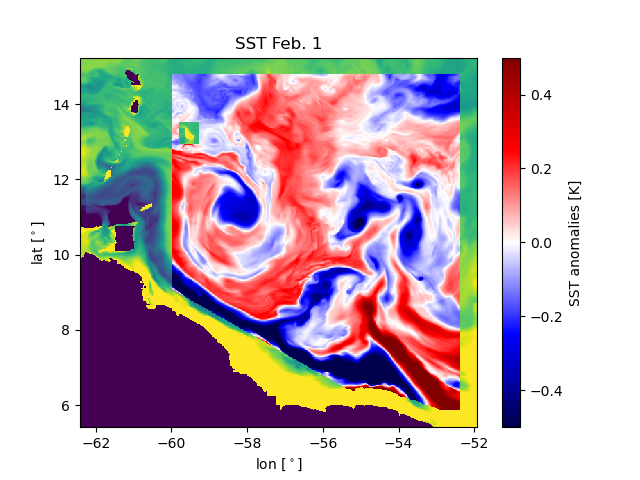

Text(0, 0.5, 'lat [$^\\circ$]')

In [19]:
day = int(0)
x = (sst_day[day])*(sst_day[day]/sst_day[day])
mesh = plt.pcolormesh(lon, lat, x, vmin=25, vmax=27, cmap='viridis')
# plt.colorbar(mesh, label='SST [$^\circ$C]', extend='both')

mesh_anoms = plt.pcolormesh(lon, lat, dsst_day[day], vmin=-0.5, vmax=0.5, cmap='seismic')
plt.colorbar(mesh_anoms, label='SST anomalies [K]')

# conts = plt.contour(lon, lat, dsst_day[day], levels=[round(perc_20[day],2), round(perc_80[day],2)], cmap='jet')
# plt.clabel(conts, inline=True)


plt.title(f'SST Feb. {day+1}')
plt.xlabel('lon [$^\circ$]')
plt.ylabel('lat [$^\circ$]')

In [22]:
dsst_day.shape

(29, 546, 573)

<IPython.core.display.Javascript object>


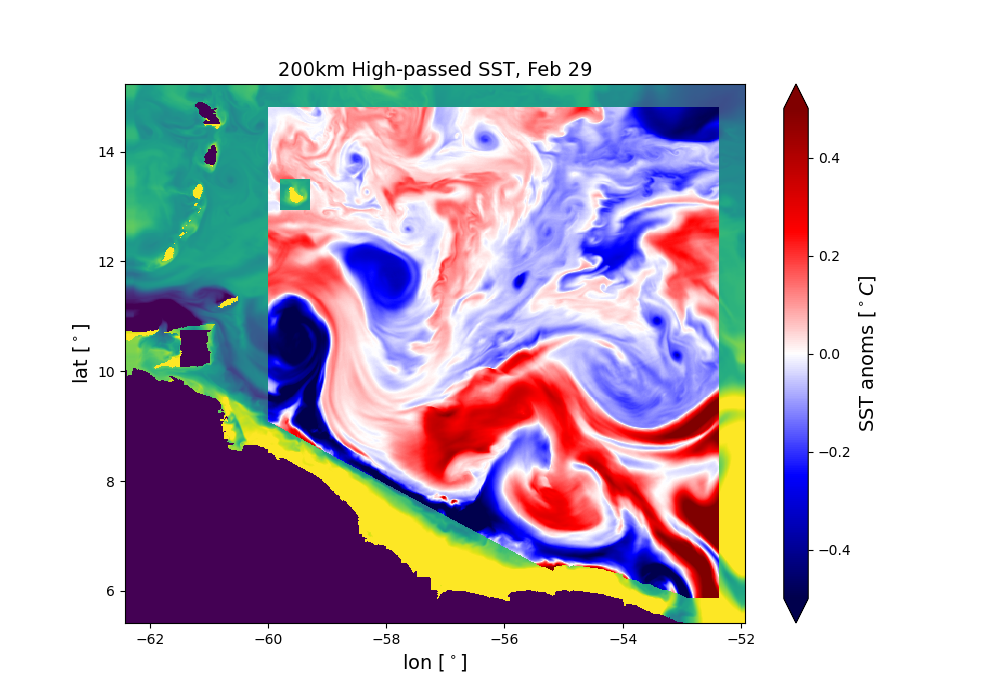

In [48]:
# enable interactive plot
%matplotlib notebook

trange = len(sst_day['day'].values)
frames = np.arange(trange)
# frames = np.arange(0,len(trange))

# date = ds_hourly['time_counter'].values.astype('<M8[s]')



# setting up the figures to be printed
fig = plt.figure(figsize=(10,7))
ax = plt.axes(xlim=(lon[0,0], lon[0,-1]), ylim=(lat[0,0], lat[-1,0]), xlabel='lon [$^\circ$]', ylabel='lat [$^\circ$]')
ax.set_title(f'SST, Feb {1}',  fontsize=14) 


# initial  plot - SST
sst_masksss = (sst_day[0]/sst_day[0])
x = (sst_day[0])*sst_masksss
mesh = ax.pcolormesh(lon, lat, x, vmin=25, vmax=27, cmap='viridis')
cbar = fig.colorbar(mesh, extend='both')
cbar.set_label('SST [$^\circ C$]', fontsize=14)


# initial  plot - dSST
# norm = colors.TwoSlopeNorm(vmin=np.nanmin(dsst_day), vcenter=0., vmax=np.nanmax(dsst_day))

# dsst_levs_min= np.linspace(np.nanmin(dsst_day),0,13);  dsst_levs_max=np.linspace(0,np.nanmax(dsst_day), 9)
# dsst_levs = np.concatenate( (dsst_levs_min, dsst_levs_max))
# dsst_levs = np.unique(dsst_levs)

#adj_levs = dsst_levs - 0.5*(np.nanmin(dsst)+np.nanmax(dsst)) 
# contf = ax.pcolormesh(lon, lat, dsst_day[0,:,:],  cmap='seismic', vmin=-0.5, vmax=0.5)

# cbar = fig.colorbar(contf, extend='both')
# cbar.set_label('SST anoms [$^\circ C$]', fontsize=14)
# cbar.set_ticks(dsst_levs)
# cbar.set_ticklabels(dsst_levs.round(decimals=1).astype(str))


# Animation function
def animate(i):
    ax.clear()     # clear previous plot
    
    x = (sst_day[i])*sst_masksss
    mesh = ax.pcolormesh(lon, lat, x, vmin=25, vmax=27, cmap='viridis')
    ax.set_xlabel('lon [$^\circ$]', fontsize=14); ax.set_ylabel('lat [$^\circ$]',fontsize=14)
    cbar.update_normal(mesh)
    ax.set_title(f'SST, Feb {i+1}',  fontsize=14)
    
    if i >= 10:
        contf = ax.pcolormesh(lon, lat, dsst_day[i,:,:], cmap='seismic', vmin=-0.5, vmax=0.5)
        cbar.set_label('SST anoms [$^\circ C$]', fontsize=14)
        cbar.update_normal(contf)
#         cbar.set_ticks(dsst_levs)
#         cbar.set_ticklabels(dsst_levs.round(decimals=1).astype(str))
        ax.set_title(f'200km High-passed SST, Feb {i+1}',  fontsize=14)

anima_dsst = animation.FuncAnimation(fig, animate, interval=100, frames=frames, repeat=False)

plt.show()


In [49]:
writer = PillowWriter(fps=1,metadata=dict(artist='Me'),bitrate=800)
anima_dsst.save('/venus/tesi_ale/img_EU/SST/SST_exchanging_presentation.gif', writer=writer)

<IPython.core.display.Javascript object>


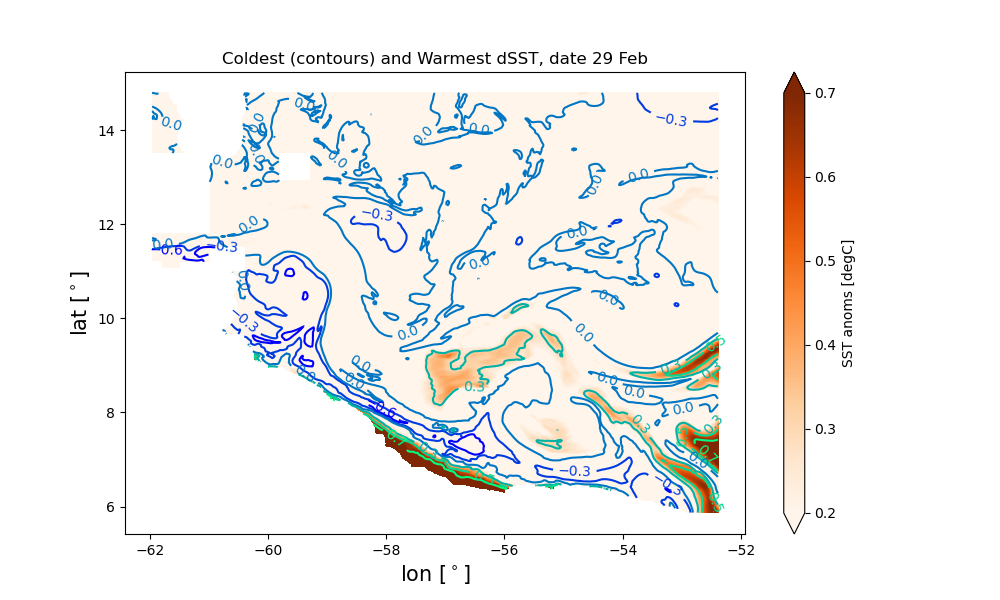

In [39]:
%matplotlib notebook

trange = 29                         #len(ds_hourly['time_counter'].values)
trange = np.arange(trange)
frames = np.arange(0,len(trange))
levs = [-0.6, -0.3, 0., 0.3, 0.5, 0.7]
mindsst, maxdsst = 0.2, 0.7
cont_cmap = 'winter'
mesh_cmap = 'Oranges'

# setting up the figures to be printed
fig = plt.figure(figsize=(10,6))
ax = plt.axes(xlim=(lon_M[0,0], lon_M[0,-1]), ylim=(lat_M[0,0], lat_M[-1,0]), xlabel='lon [$^\circ$]', ylabel='lat [$^\circ$]')

# set initial plot
contf = ax.pcolormesh(lon_M, lat_M, dsst_day[0,:,:], vmin=mindsst, vmax=maxdsst, cmap=mesh_cmap)  
cbar = fig.colorbar(contf, extend='both')
cbar.set_label('SST anoms [degC]')

cont = ax.contour(lon_M, lat_M, dsst_day[0,:,:], levels=levs, cmap=cont_cmap)
ax.clabel(cont, inline=True, fontsize=10)

ax.set_xlabel('lon [$^\circ$]', fontsize=15); ax.set_ylabel('lat [$^\circ$]',fontsize=15)
ax.set_title(f'Coldest (contours) and Warmest dSST')




# Animation function
def animate(i):
    ax.clear()     # clear previous plot
     
    contf = ax.pcolormesh(lon_M, lat_M, dsst_day[i,:,:], vmin=mindsst, vmax=maxdsst, cmap=mesh_cmap)  
    cbar.update_normal(contf)
    #cbar.set_ticks(dsst_levs)
    #cbar.set_ticklabels(dsst_levs.round(decimals=1).astype(str))
    
    cont = ax.contour(lon_M, lat_M, dsst_day[i,:,:], levels=levs, cmap=cont_cmap)
    ax.clabel(cont, inline=True, fontsize=10)
    
    ax.set_xlabel('lon [$^\circ$]', fontsize=15); ax.set_ylabel('lat [$^\circ$]',fontsize=15)
    ax.set_title(f'Coldest (contours) and Warmest dSST, date {trange[i]+1} Feb') 


anima_dsst = animation.FuncAnimation(fig, animate, interval=200, frames=frames, repeat=False)

plt.show()

In [38]:
writer = PillowWriter(fps=1,metadata=dict(artist='Me'),bitrate=1800)
anima_dsst.save('/venus/tesi_ale/img_EU/SST/warmest_coldest_dsst.gif', writer=writer)